# Time Series Forecasting: Predicting Bitcoin Price


The cryptocurrency market has seen its rise and fall in the past few years. With a variety of coins being exchanged for real money, it is important to know the trend in the coin price. In this article, we will build a fairly simple LSTM network to predict or forecast the prices of Bitcoin.

## Obtaining Bitcoin Data

There are plenty of open sources available on the internet to extract historical data of Bitcoin prices. The one that I have used below is from Coinmarketcap.

You can view and download the dataset [here](https://coinmarketcap.com/currencies/bitcoin/historical-data/).


## Step 1. Loading and Understanding The Data

In [0]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
#Importing the data
complete_data = pd.read_excel('Bitcoins_data/BitCoin_Full_Aug_20.xlsx')

#Displaying the first 10 rows
complete_data.head(10)


,Date,Open,High,Low,Close,Volume,Market Cap
0,"Aug 20, 2019",10916.35,10947.04,10618.96,10763.23,15053082175,192530283565
1,"Aug 19, 2019",10350.28,10916.05,10313.20,10916.05,16038264603,195243306008
2,"Aug 18, 2019",10233.01,10487.07,10119.09,10345.81,12999813869,185022920955
3,"Aug 17, 2019",10358.72,10452.62,10086.70,10231.74,13778035685,182966857173
4,"Aug 16, 2019",10319.42,10524.35,9855.48,10374.34,20228207096,185500055339
5,"Aug 15, 2019",10038.42,10437.41,9675.32,10311.55,22899115082,184357666577
6,"Aug 14, 2019",10889.49,10889.56,10028.14,10051.70,19990838300,179692803424
7,"Aug 13, 2019",11385.05,11420.05,10830.33,10895.83,16681503537,194762696644
8,"Aug 12, 2019",11528.19,11528.19,11320.95,11382.62,13647198229,203441494985
9,"Aug 11, 2019",11349.74,11523.58,11248.29,11523.58,15774371518,205941632235


In [0]:
#Printing the dataset info
print(complete_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 7 columns):
Date          2306 non-null object
Open          2306 non-null float64
High          2306 non-null float64
Low           2306 non-null float64
Close         2306 non-null float64
Volume        2306 non-null object
Market Cap    2306 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 126.2+ KB
None


**Key Observations:** 

* The dataset has 7 features/columns.
* The Date colum is of type object and has to be converted to datetime.
* The data is arranges in the decreasing order of date which has to be reversed


**Note**

In this project, we will try to predict the closing price of bitcons and will only focus on Date, Open and Close columns in the dataset.




## Step 2. Creating Training and Test Data


**Important Note:**

The dataset consists of observations in the decreasing order of date. We need to preserve this serial nature of the data and hence we cannot split the data randomly. So We will perform a straight forward approach to splitting the dataset.


In [0]:
#Setting The training set ratio
training_ratio = 80

#Calculating the test set ratio
test_ratio = 100-training_ratio

#Rounding the training set length to avoid fractions
training_len = round(len(complete_data)*(training_ratio/100))

#Setting the Test set length
test_len = round(len(complete_data)-training_len)

#Splitting the data based on the calculated lengths
dataset_train = complete_data.tail(training_len)
dataset_test = complete_data.head(test_len)

#Printing the shapes of training and test sets

print("Shape Of Training Set :", dataset_train.shape)
print("Shape Of Test Set :", dataset_test.shape)



Shape Of Training Set : (1845, 7)
Shape Of Test Set : (461, 7)


In [0]:
#Printing the training and test sets
print(dataset_test.tail(10))
print(dataset_train.head(10))

             Date     Open     High      Low    Close      Volume    Market Cap
451  May 26, 2018  7486.48  7595.16  7349.12  7355.88  4051539968  125469061263
452  May 25, 2018  7592.30  7659.14  7392.65  7480.14  4867829760  127573690458
453  May 24, 2018  7561.12  7738.60  7331.14  7587.34  6049220096  129385391552
454  May 23, 2018  8037.08  8054.66  7507.88  7557.82  6491120128  128868479514
455  May 22, 2018  8419.87  8423.25  8004.58  8041.78  5137010176  137104106176
456  May 21, 2018  8522.33  8557.52  8365.12  8418.99  5154990080  143518943480
457  May 20, 2018  8246.99  8562.41  8205.24  8513.25  5191059968  145109512565
458  May 19, 2018  8255.73  8372.06  8183.35  8247.18  4712399872  140559162894
459  May 18, 2018  8091.83  8274.12  7974.82  8250.97  5764190208  140607667610
460  May 17, 2018  8370.05  8445.54  8054.12  8094.32  5862530048  137923772714
             Date     Open     High      Low    Close      Volume    Market Cap
461  May 16, 2018  8504.41  8508.43  817

Note:

The test set data should be the continuation of the training set data.

## Step 3. Preprocessing The Training Set

###3.1 Preparing The Data

In [0]:
#Setting the date colum to date format
dataset_train['Date'] = pd.to_datetime(dataset_train['Date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#Setting Date column as Index
dataset_train.set_index('Date', inplace = True)

In [0]:
#Sorting the dataset based on increasing Dates
dataset_train.sort_values(by='Date',ascending=True, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
print(dataset_train.head(10))

              Open    High     Low   Close Volume  Market Cap
Date                                                         
2013-04-28  135.30  135.98  132.10  134.21      -  1488566728
2013-04-29  134.44  147.49  134.00  144.54      -  1603768865
2013-04-30  144.00  146.93  134.05  139.00      -  1542813125
2013-05-01  139.00  139.89  107.72  116.99      -  1298954594
2013-05-02  116.38  125.60   92.28  105.21      -  1168517495
2013-05-03  106.25  108.13   79.10   97.75      -  1085995169
2013-05-04   98.10  115.00   92.50  112.50      -  1250316563
2013-05-05  112.90  118.80  107.14  115.91      -  1288693176
2013-05-06  115.98  124.66  106.64  112.30      -  1249023060
2013-05-07  112.25  113.44   97.70  111.50      -  1240593600


The training set has now been reorganized by arranging the data in increasing order of dates.

### 3.2 Scaling and Sequencing 

In [0]:
#A method to preprocess the data in to sequences and to return x and y 

#Initializing the MinMaxScaler object
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

def bit_pre_process(raw_data , seq_len, column = 1):
  
  #Select the feature/column 
  data = raw_data.iloc[:, column].values
  data = data.reshape(-1, 1)
  
  #Feature Scaling
  data = sc.fit_transform(data)
  
  #Making sequences
  
  X = []
  y = []

  for i in range(seq_len, len(data)):
      X.append(data[i-seq_len:i, 0])
      y.append(data[i, 0])
  X, y = np.array(X), np.array(y)

  # Reshaping
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  
  return X, y

In [0]:

#Setting the sequence length (Try different values)
sequence_length = 60

#Choosing the idex of the Close column
comumn_index= 3

#Preprocessing the training set
X_train, y_train = bit_pre_process(dataset_train , sequence_length, comumn_index)

Sequence length is the number of previous observation to consider in order to predict. For example, in this case to predict the closing price of Bitcoin at a given date, the algorithm will consider the closing price of Bitcoins for the past 60 days.



In [0]:
X_train.shape

(1785, 60, 1)

In [0]:
y_train.shape

(1785,)

The independent variable set(x_train) will now consist of 1785 observations. Each observation in x_train is a sequence of 60 closing prices i,e. the first row in x_train will be an array of the first 60 observations from the training set and the corresponding y_train will be the closing price of the 61st observation.


For a sequence length of 60, x_train and y_train will look like whats shown below:


![alt text](https://www.analyticsindiamag.com/wp-content/uploads/2019/08/x_train_y_train.png)

## Step 4. Building a Recurrent Neural Network

In [0]:
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dropout

#Initialising the RNN
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
regressor.add(CuDNNLSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(CuDNNLSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a third LSTM layer and some Dropout regularisation
regressor.add(CuDNNLSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(CuDNNLSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))


Using TensorFlow backend.
W0827 06:59:20.190963 140517615474560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 06:59:20.212590 140517615474560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 06:59:20.802672 140517615474560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 06:59:20.944375 140517615474560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

**Important Note:**

CuDNNLSTM requires a GPU to execute. If there is no GPU, use LSTM instead.

In [0]:
#Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae', 'mape', 'cosine'])


W0827 06:59:21.465149 140517615474560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
#Fitting the RNN to the Training set and training the RNN
regressor.fit(X_train, y_train, epochs = 50, batch_size = 50)

W0827 06:59:22.506163 140517615474560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/50
1785/1785 [==============================] - 5s 3ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0470 - mean_absolute_percentage_error: 18009.5261 - cosine_proximity: -0.7294
Epoch 2/50
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 10803.5762 - cosine_proximity: -0.7697
Epoch 3/50
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0222 - mean_absolute_percentage_error: 4164.4187 - cosine_proximity: -0.7899
Epoch 4/50
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0224 - mean_absolute_percentage_error: 4340.1881 - cosine_proximity: -0.8034
Epoch 5/50
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0239 

## Step 5. Predicting For The Test Set

### 5.1 Preparing Test Data

In [0]:
#Displaying the dataset
dataset_test.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Aug 20, 2019",10916.35,10947.04,10618.96,10763.23,15053082175,192530283565
1,"Aug 19, 2019",10350.28,10916.05,10313.20,10916.05,16038264603,195243306008
2,"Aug 18, 2019",10233.01,10487.07,10119.09,10345.81,12999813869,185022920955
3,"Aug 17, 2019",10358.72,10452.62,10086.70,10231.74,13778035685,182966857173
4,"Aug 16, 2019",10319.42,10524.35,9855.48,10374.34,20228207096,185500055339


In [0]:
#Converting the Date colum values from object to datetime format
dataset_test['Date'] = pd.to_datetime(dataset_test['Date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#Setting the Date column as Index to the dataset
dataset_test.set_index('Date', inplace = True)

In [0]:
#Sorting the data based on Increasing value of date
dataset_test.sort_values(by='Date',ascending=True, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#Displaying the prepared dataset
dataset_test.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-05-17,8370.05,8445.54,8054.12,8094.32,5862530048,137923772714
2018-05-18,8091.83,8274.12,7974.82,8250.97,5764190208,140607667610
2018-05-19,8255.73,8372.06,8183.35,8247.18,4712399872,140559162894
2018-05-20,8246.99,8562.41,8205.24,8513.25,5191059968,145109512565
2018-05-21,8522.33,8557.52,8365.12,8418.99,5154990080,143518943480


In [0]:
dataset_test.shape

(461, 6)

Now we have arranged the test data in increasing order of dates. How ever the test data is still not prepared for forecasting. In order to predict the the closing price of the first day in the test set we will require the closing prices of the previous 60 days. So we will attach the closing prices of the previous 60 days from the training set to the test set.

In [0]:
#Adding the previous 60 days cosing price to the test data
test_set = pd.concat((dataset_train.tail(sequence_length), dataset_test), axis = 0)

In [0]:
test_set.head(10)

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-03-18,7890.52,8245.51,7397.99,8223.68,6639190016,139201713268
2018-03-19,8344.12,8675.87,8182.40,8630.65,6729110016,146107514353
2018-03-20,8619.67,9051.02,8389.89,8913.47,6361789952,150909503835
2018-03-21,8937.48,9177.37,8846.33,8929.28,6043129856,151193917440
2018-03-22,8939.44,9100.71,8564.90,8728.47,5530390016,147809220250
2018-03-23,8736.25,8879.62,8360.62,8879.62,5954120192,150383574951
2018-03-24,8901.95,8996.18,8665.70,8668.12,5664600064,146818882936
2018-03-25,8612.81,8682.01,8449.10,8495.78,4569880064,143914265310
2018-03-26,8498.47,8530.08,7921.43,8209.40,5921039872,139078211968


In [0]:
test_set.shape

(521, 6)

Now test set has 521 rows (461 + 60) and is ready to be preprocessed.

In [0]:
#Preprocessing the test data
x_test, y_true = bit_pre_process(test_set , sequence_length, comumn_index)

In [0]:
x_test.shape

(461, 60, 1)

In [0]:
y_true.shape

(461,)

In [0]:
#Predicting the closing price of the test data
predicted_stock_price = regressor.predict(x_test)

In [0]:
#Inversing the scaled values 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [0]:
#Inversing the scaled actual prices from test data
real_stock_price = sc.inverse_transform(y_true.reshape(-1, 1))

## Step 6. Visualizing The Prediction

In [0]:

# A Method to plot predicted pirce vs Actual price
def plot_predictions(real_price, predicted_price, title, x_label, y_label):
  plt.plot(real_price, color = 'green', label = 'Real Stock Price')
  plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Google Stock Price')
  plt.legend()
  plt.show()

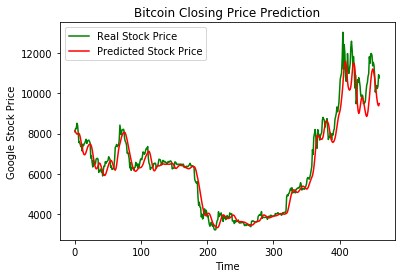

In [0]:
#Plotting real_stock_pric vs predicted_stock_price
plot_predictions(real_stock_price, predicted_stock_price, "Bitcoin Closing Price Prediction", "Time", "Closing Price")

## Step 7. Comparing the Predicted and Actual prices

In [0]:
dataset_test['Predicted_Close'] = predicted_stock_price

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
compare = dataset_test[['Open','Close','Predicted_Close' ]]

In [0]:
compare.head(20)

,Open,Close,Predicted_Close
Date,,,
2018-05-17,8370.05,8094.32,8139.000488
2018-05-18,8091.83,8250.97,8074.370605
2018-05-19,8255.73,8247.18,8019.656738
2018-05-20,8246.99,8513.25,7979.665527
2018-05-21,8522.33,8418.99,7977.018066
2018-05-22,8419.87,8041.78,8004.270996
2018-05-23,8037.08,7557.82,8016.127441
2018-05-24,7561.12,7587.34,7957.745117
2018-05-25,7592.30,7480.14,7833.638184


## Step 8. Further Analysis - Buy or Sell

In this step we will simply analyse the predicted and real closing prices and based on the data we will decide whether it is good to buy or sell the Bitcoins.

Condition :

If the closing price is greater than the opening price we will decide to sell the coins, otherwise will will buy more coins.



In [0]:
#A function to decide buy or sell (1 for sell and 0 for buy)

def buy_sell(op, cl):
  
  #If closing price is greater than the opening price, its a buy
  if cl > op:    
    return 1
  #If closing price is lesser than the opening price, its a sell 
  else:
    return 0
      

In [0]:
#Mapping the buy_sell method to the actual closing price in the test data and saving it as a column
compare["Buy-(Actual)"] = list(map(buy_sell, compare['Open'], compare['Close']))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#Mapping the buy_sell method to the predicted closing price in the test data and saving it as a column
compare["Buy-(Predicted)"] = list(map(buy_sell, compare['Open'], compare['Predicted_Close']))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#Printing the new dataframe
compare.head(10)

,Open,Close,Predicted_Close,Buy-(Actual),Buy-(Predicted)
Date,,,,,
2018-05-17,8370.05,8094.32,8139.000488,0,0
2018-05-18,8091.83,8250.97,8074.370605,1,0
2018-05-19,8255.73,8247.18,8019.656738,0,0
2018-05-20,8246.99,8513.25,7979.665527,1,0
2018-05-21,8522.33,8418.99,7977.018066,0,0
2018-05-22,8419.87,8041.78,8004.270996,0,0
2018-05-23,8037.08,7557.82,8016.127441,0,0
2018-05-24,7561.12,7587.34,7957.745117,1,1
2018-05-25,7592.30,7480.14,7833.638184,0,1


In [0]:
#Calculating Buy or Sell accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(compare['Buy-(Actual)'], compare['Buy-(Predicted)'])

In [0]:
Accuracy = cm.diagonal().sum()/cm.sum()
print("Buy or Sell Accuracy : ", Accuracy)

Buy or Sell Accuracy :  0.5075921908893709


### Best Approach

The Buy or Sell can be predicted using the RNN. In the above approach we used regression to predict the closing prices and then maped the Buy or sell method. Instead we can use the Buy/Sell as the target variable and use the RNN for categorical prediction.